<a href="https://colab.research.google.com/github/TAUforPython/denoising/blob/main/%D1%84%D0%B8%D0%BB%D1%8C%D1%82%D1%80_%D0%9A%D0%B0%D0%BB%D0%BC%D0%B0%D0%BD%D0%B0_%D0%BF%D1%80%D0%B8%D0%BC%D0%B5%D1%80_%D1%82%D1%80%D0%B0%D0%B5%D0%BA%D1%82%D0%BE%D1%80%D0%B8%D1%8F_%D0%BC%D1%8F%D1%87%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install filterpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110458 sha256=e25cc4012ce4ea9c42d5de1cf713f9e08f2763e27fdec4cdec018cc6eeb0f15a
  Stored in directory: /root/.cache/pip/wheels/0f/0c/ea/218f266af4ad626897562199fbbcba521b8497303200186102
Successfully built filterpy


In [3]:
#Импортируем необходимые библиотеки
import math
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter
from math import sin,cos,radians
import numpy as np


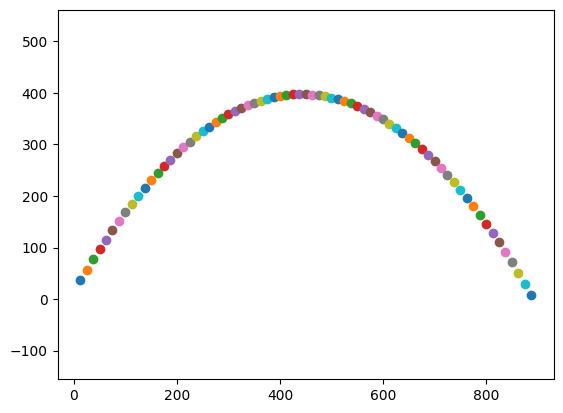

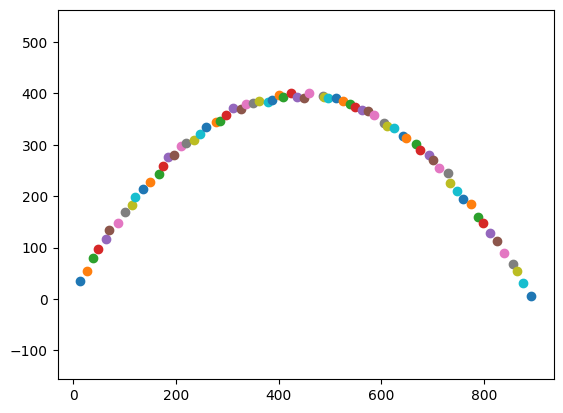

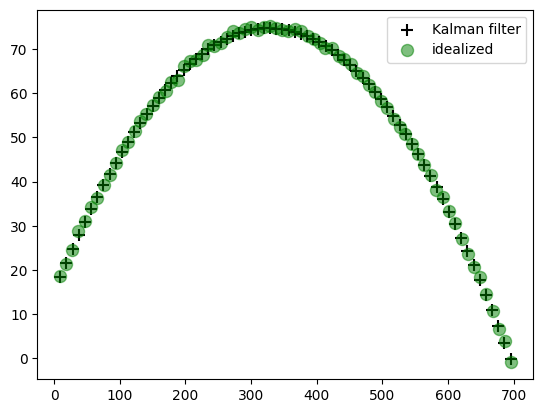

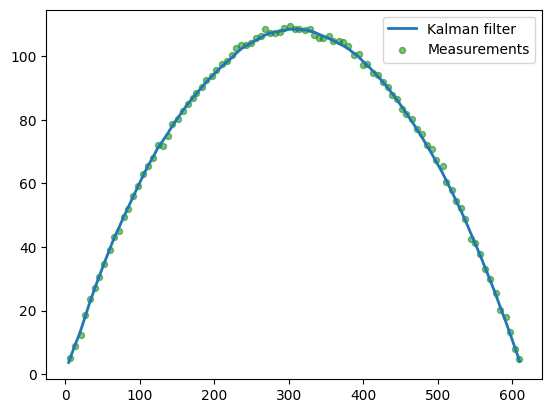

In [4]:

#Первый блок кода
def rk4(y, x, dx, f):
    k1 = dx * f(y, x)
    k2 = dx * f(y + 0.5 * k1, x + 0.5 * dx)
    k3 = dx * f(y + 0.5 * k2, x + 0.5 * dx)
    k4 = dx * f(y + k3, x + dx)
    return y + (k1 + 2 * k2 + 2 * k3 + k4) / 6.


def fx(x, t):
    return fx.vel


def fy(y, t):
    return fy.vel - 9.8 * t


class BallTrajectory2D(object):

    def __init__(self, x0, y0, velocity, theta_deg=0., g=9.8, noise=[1.0, 1.0]):
        self.x = x0
        self.y = y0
        self.t = 0
        theta = math.radians(theta_deg)
        fx.vel = math.cos(theta) * velocity
        fy.vel = math.sin(theta) * velocity
        self.g = g
        self.noise = noise

    def step(self, dt):
        self.x = rk4(self.x, self.t, dt, fx)
        self.y = rk4(self.y, self.t, dt, fy)
        self.t += dt
        return (self.x + np.random.randn() * self.noise[0], self.y + np.random.randn() * self.noise[1])


traj = BallTrajectory2D(x0=0, y0=15, velocity=100, theta_deg=60)


def test_ball_vacuum(noise):
    y = 15
    x = 0
    ball = BallTrajectory2D(x0=x, y0=y, theta_deg=60., velocity=100., noise=noise)
    t = 0
    dt = 0.25
    while y >= 0:
        x, y = ball.step(dt)
        t += dt
        if y >= 0:
            plt.scatter(x, y)

    plt.axis('equal')
    plt.show()


test_ball_vacuum([0, 0])
test_ball_vacuum([3, 3])

#Второй блок кода
def ball_kf(x, y, omega, v0, dt):
    g = 9.8
    f1 = KalmanFilter(dim_x=5, dim_z=2)
    ay = .5*dt**2
    f1.F = np.array ([[1, dt, 0, 0, 0],
                      [0, 1, 0, 0, 0],
                      [0, 0, 1, dt, ay],
                      [0, 0, 0, 1, dt],
                      [0, 0, 0, 0, 1]])

    omega = radians(omega)
    vx = cos(omega) * v0
    vy = sin(omega) * v0
    f1.Q *= 0.
    f1.x = np.array([[x, vx, y, vy, -g]]).T
    return f1

y = 15.
x = 0.
theta = 20.
v0 = 100.
dt = 0.1
ball = BallTrajectory2D(x0=x, y0=y, theta_deg=theta, velocity=v0, noise=[0.5,0.5])
f1 = ball_kf(x,y,theta,v0,dt)
t = 0

while f1.x[2,0] > 0:
    t += dt
    f1.predict()
    x,y = ball.step(dt)
    p1 = plt.scatter(f1.x[0,0], f1.x[2,0], color='black', marker='+', s=75)
    p2 = plt.scatter(x, y, color='green', marker='o', s=75, alpha=0.5)

plt.legend([p1,p2], ['Kalman filter', 'idealized'])
plt.show()

#Третий код
def ball_kf(x, y, omega, v0, dt, r=0.5, q=0.):
    g = 9.8
    f1 = KalmanFilter(dim_x=5, dim_z=2)
    ay = .5*dt**2
    f1.F = np.mat ([[1, dt, 0, 0, 0],
                    [0, 1, 0, 0, 0],
                    [0, 0, 1, dt, ay],
                    [0, 0, 0, 1, dt],
                    [0, 0, 0, 0, 1]])
    f1.H = np.mat([[1, 0, 0, 0, 0],
                   [0, 0, 1, 0, 0]])
    f1.R *= r
    f1.Q *= q

    omega = radians(omega)

    vx = cos(omega) * v0
    vy = sin(omega) * v0
    f1.x = np.mat([x,vx,y,vy,-9.8]).T
    return f1

y = 1.
x = 0.
theta = 35.
v0 = 80.
dt = 1/10.

ball = BallTrajectory2D(x0=x, y0=y, theta_deg=theta, velocity=v0, noise=[.7,.7])
f1 = ball_kf(x,y,theta,v0,dt)
t = 0
xs = []
ys = []

while f1.x[2,0] > 0:
    t += dt
    x,y = ball.step(dt)
    z = np.mat([[x,y]]).T
    f1.update(z)
    xs.append(f1.x[0,0])
    ys.append(f1.x[2,0])
    f1.predict()
    p1 = plt.scatter(x, y, color='green', marker='.', s=75, alpha=0.5)

p2, = plt.plot (xs, ys,lw=2)
plt.legend([p2,p1], ['Kalman filter', 'Measurements'])
plt.show()